In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

adcp_data = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/Data/IDC_IN2023_V01_adcp_5397/IN2023_V01_ADCP_os75nb.nc')

In [2]:
print(adcp_data)

<xarray.Dataset> Size: 5MB
Dimensions:     (time: 3864, depth_cell: 60)
Coordinates:
  * time        (time) datetime64[ns] 31kB 2023-01-25T06:45:09.999999999 ... ...
Dimensions without coordinates: depth_cell
Data variables: (12/14)
    trajectory  int32 4B ...
    lon         (time) float64 31kB ...
    lat         (time) float64 31kB ...
    depth       (time, depth_cell) float32 927kB ...
    u           (time, depth_cell) float32 927kB ...
    v           (time, depth_cell) float32 927kB ...
    ...          ...
    pflag       (time, depth_cell) int8 232kB ...
    heading     (time) float32 15kB ...
    tr_temp     (time) float32 15kB ...
    num_pings   (time) int16 8kB ...
    uship       (time) float32 15kB ...
    vship       (time) float32 15kB ...
Attributes: (12/13)
    featureType:            trajectoryProfile
    history:                Created: 2023-05-08 13:38:47 UTC
    Conventions:            COARDS
    software:               pycurrents
    hg_changeset:           32

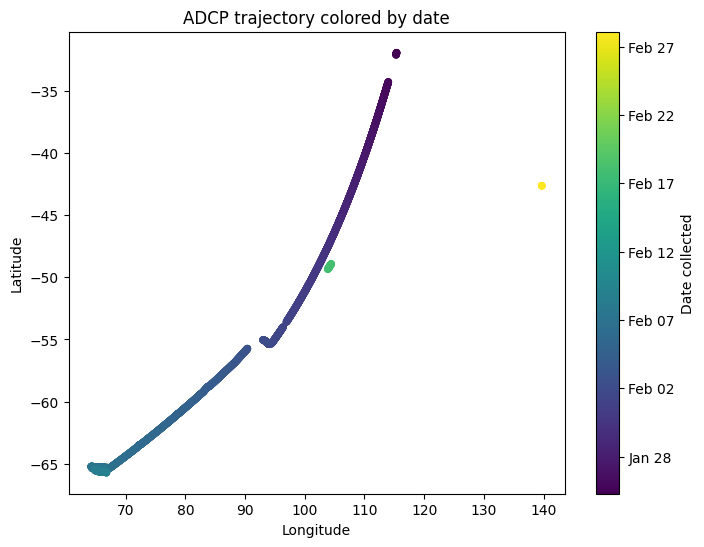

In [3]:
lon = adcp_data['lon']
lat = adcp_data['lat']
time = adcp_data['time']   # assuming you have a time coordinate

plt.figure(figsize=(8,6))
sc = plt.scatter(lon, lat, c=mdates.date2num(time.values), cmap="viridis", s=20)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("ADCP trajectory colored by date")

# Add a colorbar to show the mapping of color to time
cbar = plt.colorbar(sc)
cbar.set_label("Date collected")

cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

plt.show()


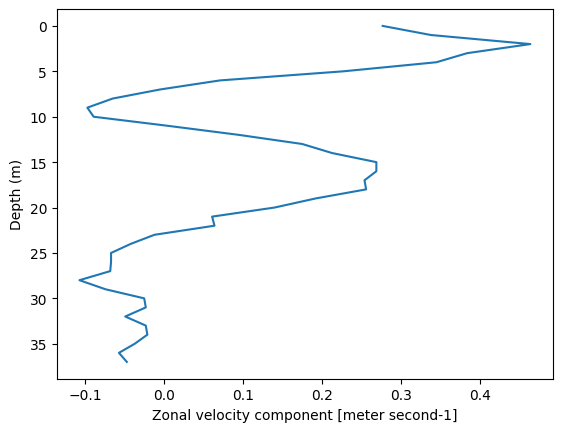

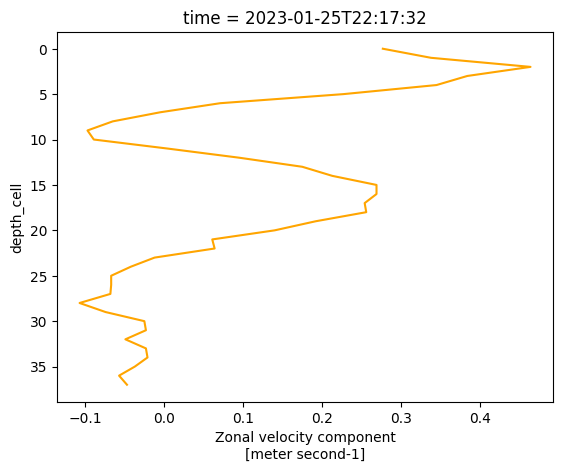

In [4]:
test_y_profile = adcp_data.u.isel(time=30)
fig, ax = plt.subplots()
ax.plot(test_y_profile.values, test_y_profile['depth_cell'].values)
ax.invert_yaxis()
ax.set_xlabel(f'{test_y_profile.attrs['long_name']} [{test_y_profile.attrs['units']}]')
ax.set_ylabel('Depth (m)')

plt.figure()
test_y_profile.plot(
    y="depth_cell",
    yincrease=False,
    color='orange',
)


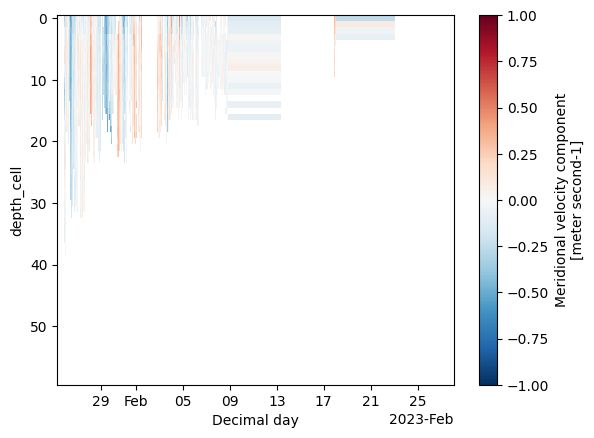

In [5]:
adcp_data.v.plot(
    x="time",
    y="depth_cell",
    yincrease=False,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1
)


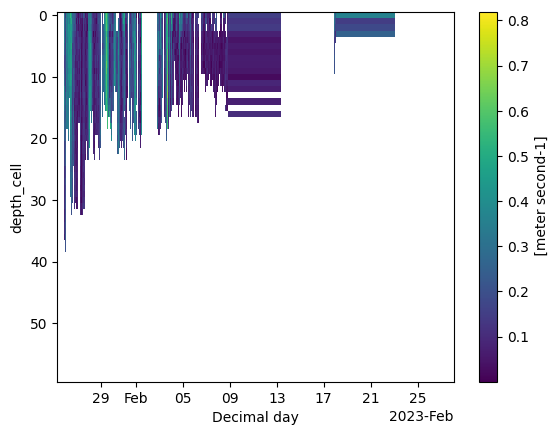

In [6]:
u = adcp_data.u
v = adcp_data.v

speed = np.sqrt((u**2 + v**2))

speed.plot(x='time',y = 'depth_cell', yincrease = False)


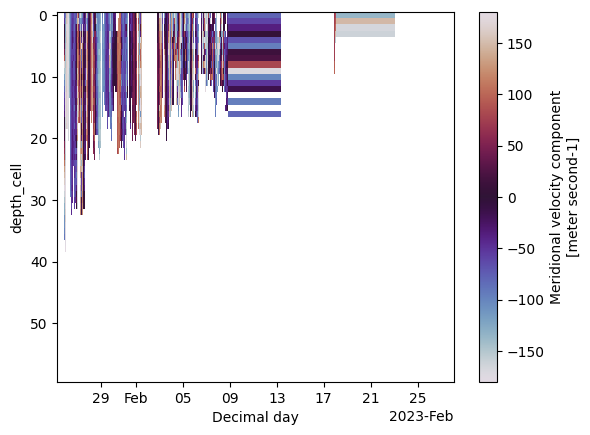

In [7]:
direction = np.degrees(np.arctan2(v, u))
direction.plot(x="time", y="depth_cell", yincrease=False, cmap="twilight")


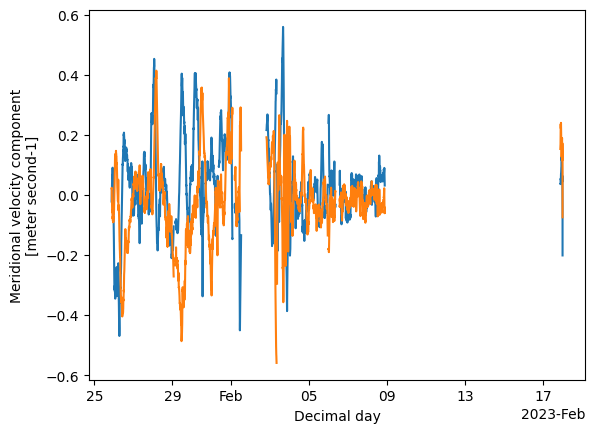

In [8]:
ave_u = u.mean("depth_cell")
ave_v =v.mean("depth_cell")

ave_u.plot(label="u")
ave_v.plot(label="v")


Text(0, 0.5, 'Latitude')

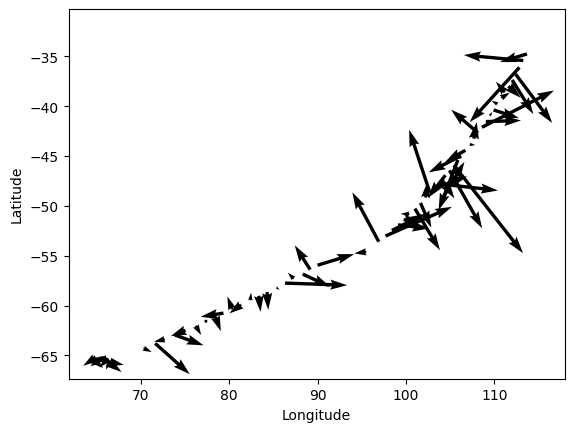

In [9]:
skip = 50
plt.quiver(
    adcp_data.lon[::skip],
    adcp_data.lat[::skip],
    ave_u[::skip],
    ave_v[::skip]
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")


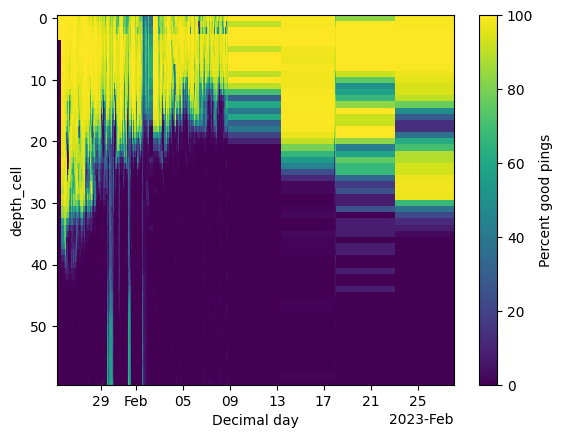

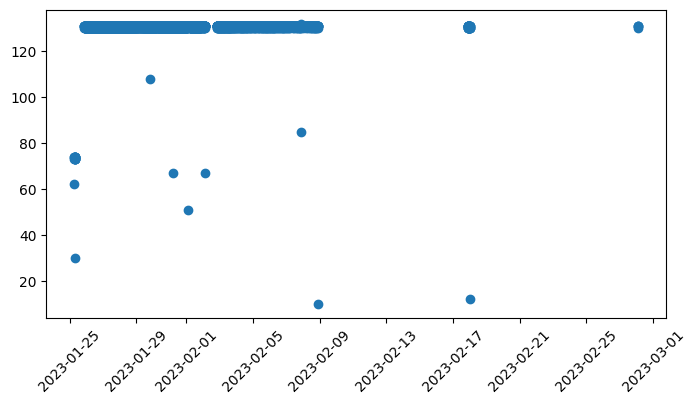

In [10]:
percent_good = adcp_data.pg
plt.figure()
percent_good.plot(x="time", y="depth_cell", yincrease=False)
plt.show()

plt.figure(figsize=(8, 4))
num_pings = adcp_data.num_pings
time = adcp_data.time
plt.scatter(time, num_pings)
plt.xticks(rotation=45)
plt.show()

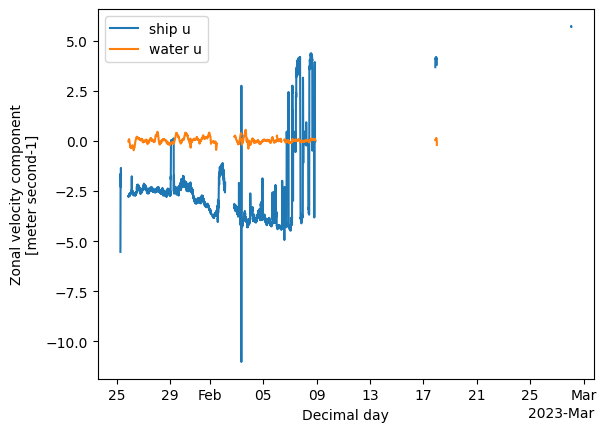

In [11]:
uship = adcp_data.uship

uship.plot(label="ship u")
ave_u.plot(label="water u")

plt.legend()


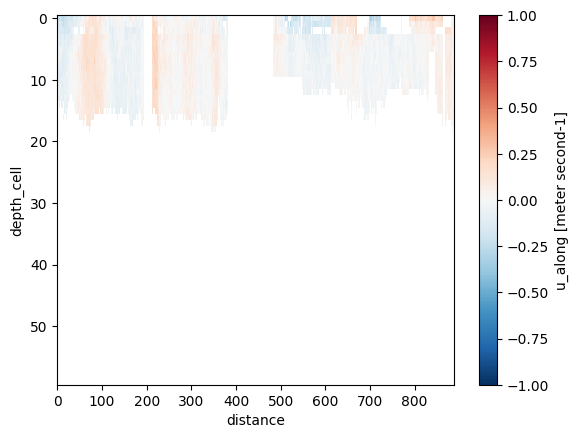

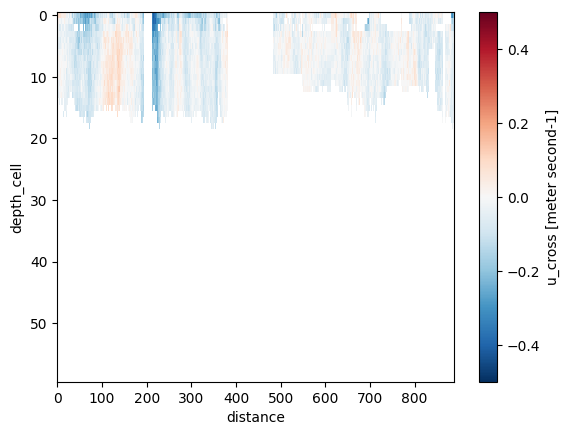

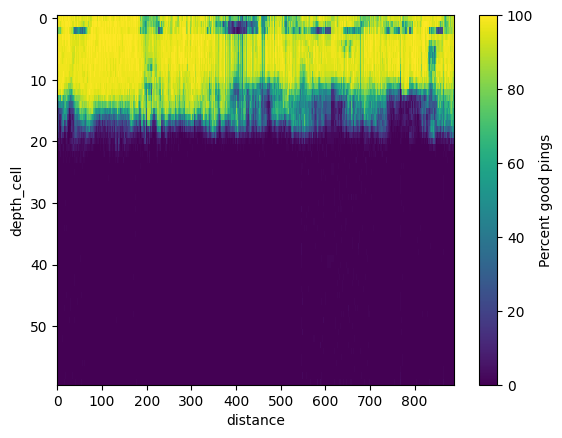

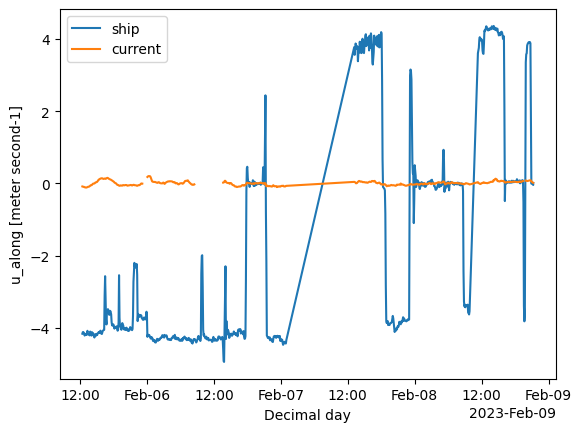

In [12]:
lon0 = 70      # example
dlon = 5 # width of selection (~25 km, depends on latitude)

mask = abs(adcp_data.lon - lon0) < dlon
transect = adcp_data.where(mask, drop=True)

# Earth radius (m)
R = 6371e3

lon = np.deg2rad(transect.lon.values)
lat = np.deg2rad(transect.lat.values)

dlon = np.diff(lon)
dlat = np.diff(lat)

a = np.sin(dlat/2)**2 + np.cos(lat[:-1]) * np.cos(lat[1:]) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
dist = R * c

s = np.concatenate([[0], np.cumsum(dist)]) / 1000  # km

transect = transect.assign_coords(distance=("time", s))

# Fit a line to lon/lat
p = np.polyfit(transect.lon, transect.lat, 1)
theta = np.arctan(p[0])  # radians, CCW from east

u = transect.u
v = transect.v

u_along =  u*np.cos(theta) + v*np.sin(theta)
u_cross = -u*np.sin(theta) + v*np.cos(theta)

transect["u_along"] = u_along
transect["u_cross"] = u_cross

plt.figure()
transect.u_along.plot(
    x="distance",
    y="depth_cell",
    yincrease=False,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1
)

plt.show()

plt.figure()
transect.u_cross.plot(
    x="distance",
    y="depth_cell",
    yincrease=False,
    cmap="RdBu_r",
    vmin=-0.5,
    vmax=0.5
)

plt.show()


plt.figure()
# Data coverage
transect.pg.plot(x="distance", y="depth_cell", yincrease=False)
plt.show()

plt.figure()
# Ship speed vs currents
transect.uship.plot(label="ship")
transect.u_along.mean("depth_cell").plot(label="current")
plt.legend()
plt.show()